# Equipo Always Learning Deeper - Universitat Politècnica de València
Autores:
* Jaime Ferrando Huertas
* Javier Iranzo Sánchez
* Javier Rodríguez Domínguez

<a name=Indice></a>
# Índice
1. [Análisis de datos](#Análisisdedatos)
 1. [Análisis de la variable dependiente](#Análisisdelavariabledependiente)
 2. [Análisis de las variables explicativas](#Análisisdelasvariablesexplicativas)
2. [Entrenamiento de modelos](#Entrenamientodemodelos)
    1. [Preparación de datos](#Preparacióndedatos)
    2. [Experimentos](#Experimentos)
    3. [Comparación de modelos](#Comparacióndemodelos)
    4. [Optimización y combinación de modelos](#Optimizacion)
3. [Predicción](#Predicción)
4. [Anexo 1: Otros modelos considerados](#Anexo1)


# Introduccion fase 2

Este notebook es una evolución del presentado para la fase 1, a partir del cual hemos probado más modelos y estudiado cómo optimizar sus hiperparámetros así como la combinación de modelos. Como resultado de todo esto, hemos mejorado nuestros resultados respecto a la fase 1 y entregado un nuevo fichero de predicciones.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.model_selection import KFold,cross_val_score
from sklearn.tree import DecisionTreeRegressor

In [2]:
#Cargamos los datos de entrenamiento
train_df = pd.read_csv("data/original/Dataset_Salesforce_Predictive_Modelling_TRAIN.txt")

/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


El objetivo de este reto es el desarollo de un modelo capaz de predecir el poder adquisitivo de un cliente a partir de una serie de variables disponibles para la entidad financiera. Contar con un modelo preciso que pueda llevar a cabo estas predicciones sin duda conllevaría muchas ventajas a la hora de recomendar productos al cliente que se adecuen a sus necesidades y capacidades.

<a name=Análisisdedatos></a>
# Análisis de datos
[Volver al Indice](#Indice)

 Veamos un ejemplo de los datos con los que contamos.

In [3]:
train_df.head()

,ID_Customer,Imp_Cons_01,Imp_Cons_02,Imp_Cons_03,Imp_Cons_04,Imp_Cons_05,Imp_Cons_06,Imp_Cons_07,Imp_Cons_08,Imp_Cons_09,...,Num_Oper_17,Num_Oper_18,Num_Oper_19,Num_Oper_20,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_04,Socio_Demo_05,Poder_Adquisitivo
0,TR000001,0.0,0.00,0.000000,63.067778,0.0,52.196667,0.0,0.000000,0.00,...,2,0,0,0,09991,1,70.44,3,20,19709.915000
1,TR000002,0.0,100.58,595.454545,10.899000,0.0,39.473636,0.0,62.268571,42.61,...,4,1,0,0,09991,2,71.87,3,29,37497.492167
2,TR000003,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,...,2,0,0,0,0X301,2,72.48,2,41,4802.970000
3,TR000004,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,...,0,0,0,0,0X301,2,86.60,3,38,8295.770000
4,TR000005,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,...,0,0,0,0,09991,2,92.48,4,35,24149.321667


In [4]:
train_df.columns

Index(['ID_Customer', 'Imp_Cons_01', 'Imp_Cons_02', 'Imp_Cons_03',
       'Imp_Cons_04', 'Imp_Cons_05', 'Imp_Cons_06', 'Imp_Cons_07',
       'Imp_Cons_08', 'Imp_Cons_09', 'Imp_Cons_10', 'Imp_Cons_11',
       'Imp_Cons_12', 'Imp_Cons_13', 'Imp_Cons_14', 'Imp_Cons_15',
       'Imp_Cons_16', 'Imp_Cons_17', 'Imp_Sal_01', 'Imp_Sal_02', 'Imp_Sal_03',
       'Imp_Sal_04', 'Imp_Sal_05', 'Imp_Sal_06', 'Imp_Sal_07', 'Imp_Sal_08',
       'Imp_Sal_09', 'Imp_Sal_10', 'Imp_Sal_11', 'Imp_Sal_12', 'Imp_Sal_13',
       'Imp_Sal_14', 'Imp_Sal_15', 'Imp_Sal_16', 'Imp_Sal_17', 'Imp_Sal_18',
       'Imp_Sal_19', 'Imp_Sal_20', 'Imp_Sal_21', 'Ind_Prod_01', 'Ind_Prod_02',
       'Ind_Prod_03', 'Ind_Prod_04', 'Ind_Prod_05', 'Ind_Prod_06',
       'Ind_Prod_07', 'Ind_Prod_08', 'Ind_Prod_09', 'Ind_Prod_10',
       'Ind_Prod_11', 'Ind_Prod_12', 'Ind_Prod_13', 'Ind_Prod_14',
       'Ind_Prod_15', 'Ind_Prod_16', 'Ind_Prod_17', 'Ind_Prod_18',
       'Ind_Prod_19', 'Ind_Prod_20', 'Ind_Prod_21', 'Ind_Prod_22',
       '

In [5]:
train_df.dtypes

ID_Customer           object
Imp_Cons_01          float64
Imp_Cons_02          float64
Imp_Cons_03          float64
Imp_Cons_04          float64
Imp_Cons_05          float64
Imp_Cons_06          float64
Imp_Cons_07          float64
Imp_Cons_08          float64
Imp_Cons_09          float64
Imp_Cons_10          float64
Imp_Cons_11          float64
Imp_Cons_12          float64
Imp_Cons_13          float64
Imp_Cons_14          float64
Imp_Cons_15          float64
Imp_Cons_16          float64
Imp_Cons_17          float64
Imp_Sal_01           float64
Imp_Sal_02           float64
Imp_Sal_03           float64
Imp_Sal_04           float64
Imp_Sal_05           float64
Imp_Sal_06           float64
Imp_Sal_07           float64
Imp_Sal_08           float64
Imp_Sal_09           float64
Imp_Sal_10           float64
Imp_Sal_11           float64
Imp_Sal_12           float64
                      ...   
Ind_Prod_21            int64
Ind_Prod_22            int64
Ind_Prod_23            int64
Ind_Prod_24   

In [6]:
len(train_df)

363834

Tal y como se explica en el enunciado, contamos con 88 variables que usar para predecir el poder adquisitivo y la información de cerca de 363.000 clientes con los que entrenar nuestro modelo. Esto hace que contemos con un número importante de datos que nos puede ayudar a desarrollar un modelo que tenga un rendimiento adecuado.

<a name=Análisisdelavariabledependiente> </a>
## Análisis de la variable dependiente 
[Volver al Indice](#Indice)  


Miremos con más detenimiento la variable a predecir.

In [7]:
train_df["Poder_Adquisitivo"].describe()

count    3.638340e+05
mean     1.642141e+04
std      2.436773e+04
min      3.600960e+03
25%      9.300933e+03
50%      1.292517e+04
75%      1.894854e+04
max      5.040000e+06
Name: Poder_Adquisitivo, dtype: float64

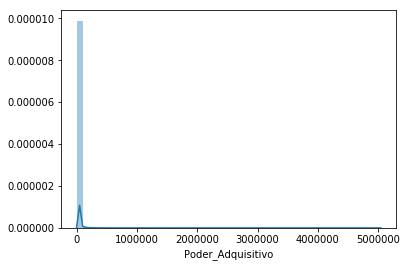

In [8]:
sns.distplot(train_df["Poder_Adquisitivo"])

In [9]:
print("Skewness: %f" % train_df["Poder_Adquisitivo"].skew())
print("Kurtosis: %f" % train_df["Poder_Adquisitivo"].kurt())

Skewness: 55.919866
Kurtosis: 7106.469270


Tal y como se puede observar en el gráfico, esta variable presenta valores extremos de skewness y kurtosis, que se manifiestan en la larga cola derecha que presenta. Esto quiere decir que existe algunos clientes que presentan valores extremadamente altos de poder adquisitivo que están muy lejos del resto. Será necesario tener en cuenta este hecho para evitar que los valores extremos puedan afectar negativamente a nuestro sistema.

Veamos de manera más detallada aquellos valores que tradicionalmente no se considerarían outliers.

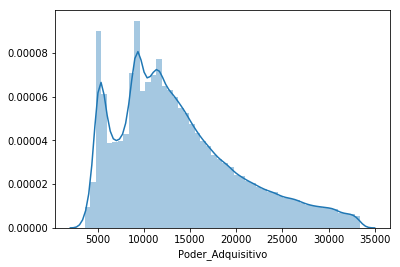

In [10]:
q1 = train_df["Poder_Adquisitivo"].quantile(0.25)
q3 = train_df["Poder_Adquisitivo"].quantile(0.75)
iqr = q3 - q1
fence_low  = q1 - 1.5 * iqr
fence_high = q3 + 1.5 * iqr

train_df_no_outliers = train_df.loc[(train_df["Poder_Adquisitivo"] > fence_low) & (train_df["Poder_Adquisitivo"] < fence_high)]
sns.distplot(train_df_no_outliers["Poder_Adquisitivo"])

In [11]:
print("Skewness: %f" % train_df_no_outliers["Poder_Adquisitivo"].skew())
print("Kurtosis: %f" % train_df_no_outliers["Poder_Adquisitivo"].kurt())

Skewness: 0.823076
Kurtosis: 0.098508


In [12]:
print("Porcentaje de datos eliminados:")
print((len(train_df.index)-len(train_df_no_outliers.index))/len(train_df.index))

Porcentaje de datos eliminados:
0.057278868934733974


Eliminando de esta manera los valores extremos, que representan alrededor del 5% de los datos totales, la distribución ahora presenta unos valores de skewness y kurtosis mucho más aceptables que permitan el entrenamiento de un modelo.

Evidentemente esta eliminación se va a realizar únicamente a la hora de entrenar, nunca a la hora de evaluar

<a name=Análisisdelasvariablesexplicativas></a>
## Análisis de las variables explicativas
[Volver al Indice](#Indice)

De las variables explicativas, sabemos que contamos con algunas que son de tipo categórico en vez de númerico. Empezemos explorando estas variables.

In [13]:
train_df_no_outliers["Socio_Demo_01"].value_counts()

09991     97865
09992     26997
09994     20758
09993     15307
0X301     15232
09511     13078
05220      8303
06110      7633
09512      7098
06120      4987
07121      4530
04500      3986
05120      3554
08432      2732
09210      2596
9992.0     2586
06300      2501
9991.0     2443
09602      2324
04111      2221
04309      2181
09700      1914
05000      1595
03613      1565
02240      1527
02230      1491
9512.0     1481
9994.0     1407
03611      1328
05110      1326
          ...  
2936.0        1
2933.0        1
2462.0        1
2463.0        1
2473.0        1
2653          1
2324.0        1
7405          1
7618.0        1
3152          1
7617          1
7192          1
3622          1
7193.0        1
3539          1
3533          1
2640.0        1
3523          1
3403.0        1
2154          1
2156          1
2157          1
2158.0        1
7611          1
3323          1
3317          1
3316.0        1
3153          1
2311          1
7311.0        1
Name: Socio_Demo_01, Len

Podemos observar como Socio_Demo_01 cuenta con muchos valores que solo aparecen un número muy bajo de veces. A la hora de transformar para su uso, es probable que la inclusión de los 921 valores posibles no aporte información discriminativa y solo sirva para aumentar el número de dimensiones. Una primera aproximación que mantenga un equilibrio entre complejidad y utilidad puede ser usar solo un subconjunto de estos valores, aquellos que aparezcan un mayor número de veces, y condensar el resto en una categoría "Other".

In [14]:
topk_socio_01 = train_df_no_outliers["Socio_Demo_01"].value_counts()[:10]
topk_socio_01

09991    97865
09992    26997
09994    20758
09993    15307
0X301    15232
09511    13078
05220     8303
06110     7633
09512     7098
06120     4987
Name: Socio_Demo_01, dtype: int64

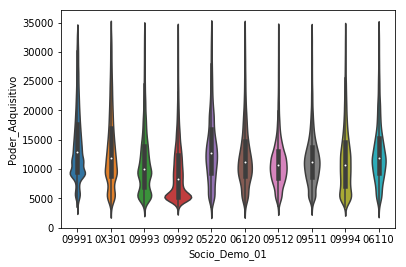

In [15]:
socio_01_keys = list(topk_socio_01.keys())
condition_array = [False] * len(train_df_no_outliers["Socio_Demo_01"])
for i in range(len(condition_array)):
    condition_array[i] = str(train_df_no_outliers["Socio_Demo_01"].iloc[i]) in socio_01_keys

sns.violinplot(x=train_df_no_outliers["Socio_Demo_01"].loc[condition_array],y=train_df_no_outliers["Poder_Adquisitivo"].loc[condition_array])

Es interesante observar que algunos valores como 09992 parecen concentrar la mayor parte de clientes en valores diferentes del resto, lo cual puede aportar información importante.

In [16]:
train_df_no_outliers["Socio_Demo_02"].value_counts()

1    206781
2    136213
Name: Socio_Demo_02, dtype: int64

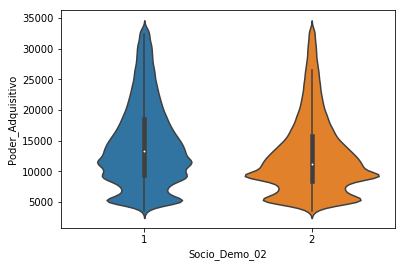

In [17]:
sns.violinplot(x=train_df_no_outliers["Socio_Demo_02"],y=train_df_no_outliers["Poder_Adquisitivo"])

Veamos el resto de variables socio demográficas.

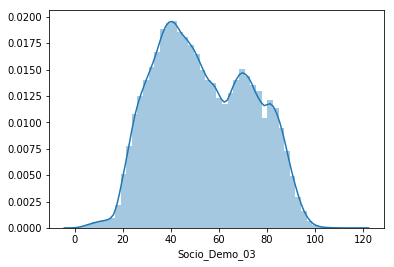

In [18]:
sns.distplot(train_df_no_outliers["Socio_Demo_03"])

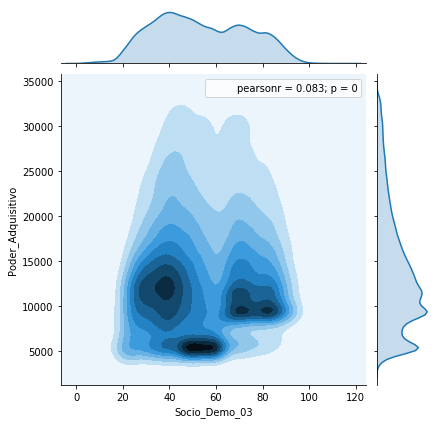

In [19]:
sns.jointplot(x=train_df_no_outliers["Socio_Demo_03"], y=train_df_no_outliers["Poder_Adquisitivo"],kind='kde')

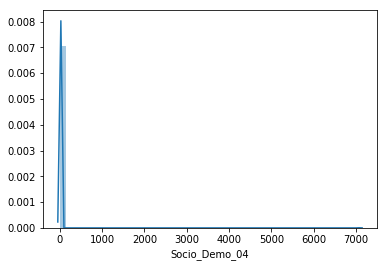

In [20]:
sns.distplot(train_df_no_outliers["Socio_Demo_04"])

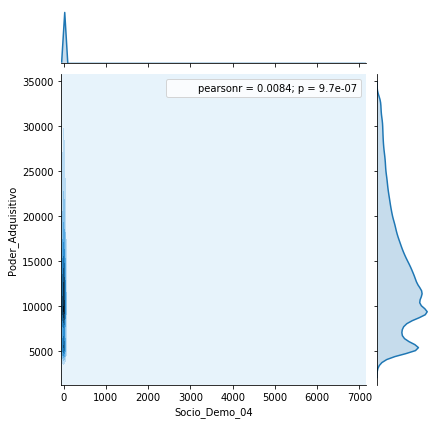

In [21]:
sns.jointplot(x=train_df_no_outliers["Socio_Demo_04"], y=train_df_no_outliers["Poder_Adquisitivo"],kind='kde')

In [22]:
train_df_no_outliers["Socio_Demo_04"].value_counts()

1       118943
2       111652
3        67361
4        33141
5         8747
6         2004
7          504
7097       280
8          149
9           56
70          42
10          21
33          20
46          20
30          14
11          11
414         10
13           8
151          6
27           2
28           2
18           1
Name: Socio_Demo_04, dtype: int64

De nuevo, observamos que una serie pequeña de valores concentra la gran mayoría de ocurrencias. Veamos si existe una relación aparente entre cada valor de esta variable y el poder adquisitivo.

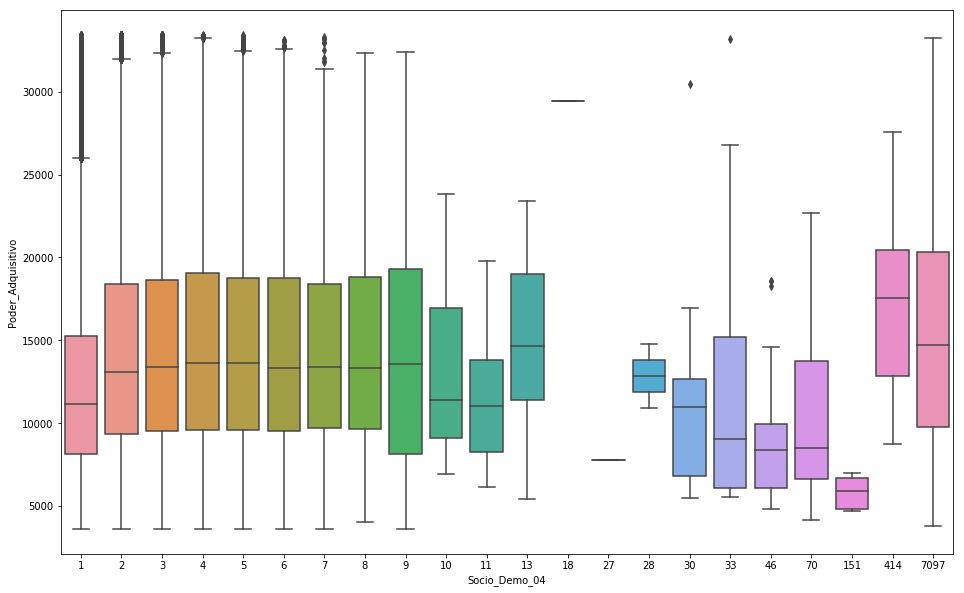

In [23]:
fig, ax = plt.subplots(figsize=(16,10))
sns.boxplot(x=train_df_no_outliers["Socio_Demo_04"], y=train_df_no_outliers["Poder_Adquisitivo"],ax=ax)

Algunos valores muestran distribuciones que son diferentes a las demás, pero aparecen un número casi insignificante de veces respecto a la totalidad de los datos.

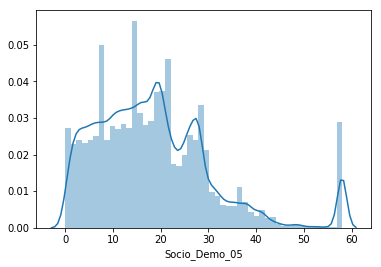

In [24]:
sns.distplot(train_df_no_outliers["Socio_Demo_05"])

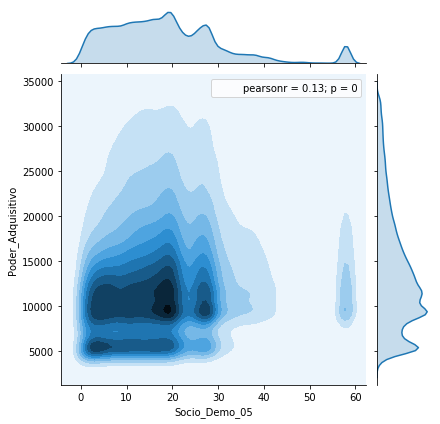

In [25]:
sns.jointplot(x=train_df_no_outliers["Socio_Demo_05"], y=train_df_no_outliers["Poder_Adquisitivo"],kind='kde')

Veamos ahora la correlación de las variables explicativas con el poder adquisitivo, medida mediante el coeficiente de Pearson.

In [26]:
train_df_no_outliers.corr(method='pearson').iloc[-1].sort_values(ascending=False,axis=0)[1:]

Imp_Sal_21       0.446199
Num_Oper_05      0.377380
Imp_Sal_19       0.364050
Ind_Prod_24      0.333431
Ind_Prod_08      0.271821
Imp_Sal_12       0.268169
Num_Oper_18      0.267717
Ind_Prod_11      0.263711
Imp_Cons_02      0.254591
Imp_Sal_08       0.254518
Imp_Cons_12      0.251392
Imp_Cons_06      0.243734
Imp_Sal_20       0.235902
Ind_Prod_05      0.229769
Imp_Cons_04      0.228519
Imp_Sal_09       0.224180
Ind_Prod_21      0.223633
Imp_Sal_04       0.221237
Imp_Cons_09      0.221097
Imp_Cons_01      0.219669
Imp_Cons_16      0.218312
Num_Oper_06      0.218307
Num_Oper_15      0.207412
Imp_Cons_03      0.203556
Ind_Prod_09      0.203247
Imp_Sal_15       0.202924
Num_Oper_02      0.196814
Imp_Sal_16       0.196771
Imp_Cons_08      0.191842
Num_Oper_08      0.190259
                   ...   
Imp_Sal_18       0.052718
Ind_Prod_04      0.051391
Ind_Prod_13      0.050400
Num_Oper_20      0.050110
Imp_Cons_14      0.049796
Num_Oper_13      0.049279
Num_Oper_09      0.042742
Num_Oper_14 

Algunas variables presentan coeficientes de correlación medios, lo que indica que serán útiles para los modelos.

<a name=Entrenamientodemodelos></a>
# Entrenamiento de modelos
[Volver al Indice](#Indice)


<a name=Preparacióndedatos></a>
## Preparación de datos
Con todo lo visto anteriormente estamos listos para preparar los datos para la experimentación. Vamos a definir una función que realice este preprocesado de los datos. 

La transformación básica consiste en convertir las variables categóricas a valores one-hot, y eliminar la columna ID_Customer que no es más que un identificador del cliente.


Con processing_type = 1 se puede indicar además que queremos filtrar los outliers (pero únicamente en tiempo de entrenamiento).



In [27]:
def process_df(df,processing_type,train = True):
    if processing_type == 1:
        return process_df_1(df,train)
    else:
        return process_df_1(df,False)
    
def process_df_1(df,train = True):
    df = df.drop(labels=["ID_Customer"],axis=1)
    
    if train:
        # Eliminamos los outliers solo en el caso de que estemos entrenando
        q1 = df["Poder_Adquisitivo"].quantile(0.25)
        q3 = df["Poder_Adquisitivo"].quantile(0.75)
        iqr = q3 - q1
        fence_low  = q1 - 1.5 * iqr
        fence_high = q3 + 1.5 * iqr

        df = df.loc[(df["Poder_Adquisitivo"] > fence_low) & (df["Poder_Adquisitivo"] < fence_high)]
    
        
    
    # Convertimos las variables a one-hot

    # Socio_Demo_01
    
    topk_socio_01 = df["Socio_Demo_01"].value_counts()[:10]
    socio_01_keys = list(topk_socio_01.keys())
    
    for key in socio_01_keys:
        on = df["Socio_Demo_01"] == key
        df.insert(loc=len(df.columns), column="Socio_Demo_01_"+str(key), value=on.astype(int))
    
    # El resto lso agrupamos en 'Other'
    condition_array = [False] * len(df["Socio_Demo_01"])
    for i in range(len(condition_array)):
        condition_array[i] = str(df["Socio_Demo_01"].iloc[i]) not in socio_01_keys
    df.insert(loc=len(df.columns), column="Socio_Demo_01_Other", value=condition_array)
    df["Socio_Demo_01_Other"] = df["Socio_Demo_01_Other"].astype(int)
    
    df = df.drop(axis=1, columns=["Socio_Demo_01"])
    
    # Socio_Demo_02
    c1=df["Socio_Demo_02"] == 1
    c2=df["Socio_Demo_02"] == 2
    df.insert(loc=len(df.columns), column="Socio_Demo_02_01", value=c1.astype(int))
    df.insert(loc=len(df.columns), column="Socio_Demo_02_02", value=c2.astype(int))
    
    df = df.drop(axis=1, columns=["Socio_Demo_02"])

    
    # Convertimos todas las columnas Ind_prod a one-hot
    
    for i in range(1,25):
        column_name = "Ind_Prod_" + str(i).zfill(2)
        c0=df[column_name] == 0
        c1=df[column_name] == 1
        c2=df[column_name] == 2
        
        df.insert(loc=len(df.columns), column=column_name + "_00", value=c0.astype(int))
        df.insert(loc=len(df.columns), column=column_name + "_01", value=c1.astype(int))
        df.insert(loc=len(df.columns), column=column_name + "_02", value=c2.astype(int))
    
        df = df.drop(axis=1, columns=[column_name])
    
    
    
    return df

En primer lugar vamos a reordenar aleatoriamente los datos, y a continuación realizar una partición de los datos para evaluar los resultados mediante **validación cruzada** en 5 bloques, con el objetivo de estimar los errores de los diferentes modelos de manera correcta y fiable. De esta manera, la tasa de entrenamiento efectiva es del 80%, y la tasa de test efectiva es del 100%.

El siguiente método divide los datos en los conjuntos de entrenamiento y test para cada partición, y los almacena en la variable splits.

In [28]:
SEED = 4
K = 5

shuffled_data = train_df.sample(frac=1,replace=False,random_state=SEED)

kf = KFold(n_splits=K)
kf.get_n_splits(shuffled_data)

def get_splits(kf,processing_type):
    splits=[]
    for train_index, test_index in kf.split(shuffled_data):
        train_data = shuffled_data.loc[train_index]
        test_data = shuffled_data.loc[test_index]

        train_data_proc = process_df(train_data,processing_type,train=True)
        test_data_proc = process_df(test_data,processing_type,train=False)


        splits.append((train_data_proc,test_data_proc))
    return splits


<a name=Experimentos></a>
## Experimentos
[Volver al Indice](#Indice)

En lo que se refiere a métricas, en primer lugar hemos escogido la **ráiz del error cuadrático medio (RMSE)**, una de las métricas más comunes para evaluar modelos de regresión. El problema que tiene esta métrica es que penaliza de manera desmedida fallos grandes. Resulta mucho más interesante medir el funcionamiento del algoritmo con una métrica que refleje mejor su funcionamiento con la mayoría de clientes, cosa que consideramos más útil a la hora de decidirnos por un modelo u otro. Por eso medimos los resultados con respecto a la **media del error absoluto (MAE)** y a la **mediana del error (MAD).** Esta última métrica no es susceptible a outliers y nos permite conocer mejor cual es el comportamiento "medio" de cada modelo.

In [29]:
%%latex

\begin{equation}
RMSE = \sqrt{\sum_{n=1}^N \frac{(y - \hat y)^2}{N}}
\end{equation}


\begin{equation}
MAE = \sum_{n=1}^N \frac{|y-\hat y|}{N}
\end{equation}


\begin{equation}
MAD = \widetilde{|y-\hat y|}
\end{equation}


<IPython.core.display.Latex object>

De las 3, vamos a fijarnos sobre todo en la tercera métrica, el MAD, para seleccionar el mejor modelo, aunque reproducimos las otras 2 estadísticas ya que también aportan información.

Dado un modelo y los splits que hemos realizado a los datos, a continuación definimos una función que, para cada partición de entrenamiento y test, entrene un modelo con los datos de entrenamiento correspondiente y calcule métricas sobre el conjunto de validación.

In [29]:
def train_and_evaluate(model,splits,skcompat=False,scaler=None):
    rmse = []
    mae = []
    mad = []
    # Para cada iteración de validación cruzada
    for s in range(len(splits)):
        train_data_proc,test_data_proc = splits[s]
        
        # Obtenemos los datos de entrenamiento
        x_train = train_data_proc.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
        y_train = train_data_proc["Poder_Adquisitivo"].as_matrix()

        # Obtenemos los datos de test
        x_test = test_data_proc.drop(labels=["Poder_Adquisitivo"], axis=1).as_matrix()
        y_test = test_data_proc["Poder_Adquisitivo"].as_matrix()
        
        # Damos la posiblidad de usar un scaler
        if scaler is not None:
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)
           
        # Caso base, entrenamos un modelo y obtenemos las predicciones
        if not skcompat:
            model.fit(X=x_train,y=y_train)
            
            # For compatibility with XGBoost
            # yhat = model.predict(X=x_test)
            yhat = model.predict(x_test)
        
        # En el caso de que sea un objeto skcompat, las llamadas a los métodos son ligeramente diferentes.
        else:
            model.fit(x=x_train,y=y_train,steps=STEPS)
            yhat = model.predict(x=x_test)['scores']
        
        # Calculamos métricas 
        rmse.append(math.sqrt(mean_squared_error(y_true=y_test, y_pred=yhat)))
        mae.append(mean_absolute_error(y_true=y_test,y_pred=yhat))
        mad.append(median_absolute_error(y_true=y_test,y_pred=yhat))
        
    return (rmse,mae,mad)

Por último, definimos un método para guardar los resultados para su posterior visualización.

In [30]:
scores = {'modelo':[], 'rmse':[],'mae':[],'mad':[]}

def record_scores(name,rmse,mae,mad):
    scores['modelo'].append(name)
    scores['rmse'].append(rmse)
    scores['mae'].append(mae)
    scores['mad'].append(mad)

A continuación vamos a exponer una serie de resultados que hemos obtenido evaluando diferentes modelos. Cabe destacar que la cantidad de experimentos realizada es mucho mayor de la mostrada aquí, pero se ha llevado a cabo una selección de aquellos que, a nuestro juicio, son más interesantes. En caso contrario este documento hubiera sido todavía más largo de lo que ya es.

En el apartado [Anexo 1](#Anexo1) del final del documento se muestran con mayor detalle más resultados de probar otros modelos y realizar diferentes exploraciones de parámetros. A continuación hemos seleccionado aquellos modelos que han obtenido mejores resultados dentro de su categoría o que consideramos que tienen interés especial.

En primer lugar probaremos diferentes modelos tras aplicar el preproceso en el que eliminamos **outliers.**

In [31]:
splits = []
splits = get_splits(kf,1)

Como primer modelo probamos la regresión lineal, ya que es el sistema más básico posible a partir del cual iremos midiendo las respectivas mejoras que vayamos realizando.


In [32]:
model = LinearRegression()
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('Linear Regresion',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 21866.239828
MAE: 5257.209822
MAD: 3039.409075


Después de realizar varias pruebas, hemos entrenado una red neuronal de 4 capas que obtiene los siguientes resultados:

In [33]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(50,50,50,50),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('ANN50*4',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 21702.603384
MAE: 4728.631802
MAD: 2397.541365


A continuación probamos diferentes modelos basados en árboles, empezando por el más simple, un regresor formado por un único árbol.

In [34]:
model = DecisionTreeRegressor(min_samples_split=200, min_samples_leaf=50, random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('RegressionTree',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 22670.479224
MAE: 4802.948535
MAD: 2223.817397


Pasamos ahora a los modelos **ensemble** que combinan varias árboles, empezando con un Random Forest.

In [35]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=23, max_features='log2',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('RF_d23',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 22861.309229
MAE: 5112.145407
MAD: 2549.585133


In [36]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=23, max_features='auto',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('RF_d23_FULL',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 22655.050330
MAE: 4621.045433
MAD: 2059.083895


La diferencia entre los dos modelos anteriores es que en el segundo caso el parámetro max_features='auto' indica que queremos permitir que se hagan splits sobre todas las variables. Como se puede apreciar, los resultados son mucho mejores que en el primer caso, pero a costa de incrementar sustancialmente el tiempo de entrenamiento.

Otro método basado en árboles es la técnica de Gradient Boosting que probamos a continuación.

In [37]:
model = GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5,max_depth=5)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('Gradient Boost_d5',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 22660.424748
MAE: 4675.047281
MAD: 2163.067239


In [38]:
model = GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5,max_depth=7)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('Gradient Boost_d7',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 22657.066140
MAE: 4597.104610
MAD: 2070.359545


A mayor profundidad del modelo, hemos obtenido mejores resultados, pero a partir de profundidad 7 los modelos empiezan a requerir un tiempo de entrenamiento mucho más elevado sin que se aprecien mejoras en el rendimiento.

Una comparación importante a realizar es comprobar si nuestra idea inicial de eliminar outliers ha dado sus frutos. Probamos ahora a entrenar una serie de modelos ***sin eliminar outliers***, que vamos a anotar en nuestra tabla de resultados con el prefijo "raw".

In [39]:
splits = []
splits = get_splits(kf,0)

In [40]:
model = LinearRegression()
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('raw Linear Regression',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 20453.694566
MAE: 5780.098872
MAD: 3266.257244


In [41]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(50,50,50,50),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('raw ANN50*4',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 20525.062038
MAE: 6248.621772
MAD: 3751.984974


In [42]:
model = GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5,max_depth=5)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('raw Gradient Boost_d5',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 19442.444211
MAE: 4790.685370
MAD: 2522.061022


In [43]:
model = GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5,max_depth=7)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('raw Gradient Boost_d7',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))


RMSE: 19659.521910
MAE: 4686.435566
MAD: 2390.403421


Aparte de sk-learn, también existen otros paquetes que implementen la técnica de GradientBoosting. Vamos a probar también entrenando modelos con este paquete.

In [44]:
model = xgb.XGBRegressor(max_depth=15, learning_rate=0.1, alpha=0,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=0.8,colsample_bytree=1.0,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw_XGB_d15',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 19061.883217
MAE: 4398.261200
MAD: 2107.846211


Una ventaja de xgboost respecto a la implementación de sk-learn es que ofrece una mayor cantidad de opciones y, muy importante, está optimizado para funcionar tanto en CPU como GPU a la vez que ofrece soporte para paralelizar el trabajo en hilos.

In [46]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=23, max_features='auto',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw RF_d23_FULL',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 18624.512787
MAE: 4408.208644
MAD: 2097.194139


Observando los resultados de todos estos modelos, si bien para los primeros modelos se puede apreciar que el filtrado de outliers supone sustanciales ganancias en términos de MAE y MAD, cuando llegamos al caso del Random Forest, el modelo que ha obtenido mejores resultados, observamos que aunque hay una pequeña diferencia de MAD, se ve compensado por una reducción muy importante en RMSE y MAE. 

<a name=Comparacióndemodelos></a>
## Comparación de modelos
[Volver al Indice](#Indice)

Vamos a observar con más detalle los resultados de los diferentes modelos, aprovechándonos de que hemos ido guardando los diferentes resultados para mostrarlos ahora de forma gráfica.

In [47]:
scores_df = pd.DataFrame(data=scores)

scores_df = scores_df.set_index('modelo')

display(scores_df)

,mad,mae,rmse
modelo,,,
Linear Regresion,3039.409075,5257.209822,21866.239828
ANN50*4,2397.541365,4728.631802,21702.603384
RegressionTree,2223.817397,4802.948535,22670.479224
RF_d23,2549.585133,5112.145407,22861.309229
RF_d23_FULL,2059.083895,4621.045433,22655.050330
Gradient Boost_d5,2163.067239,4675.047281,22660.424748
Gradient Boost_d7,2070.359545,4597.104610,22657.066140
raw Linear Regression,3266.257244,5780.098872,20453.694566
raw ANN50*4,3751.984974,6248.621772,20525.062038


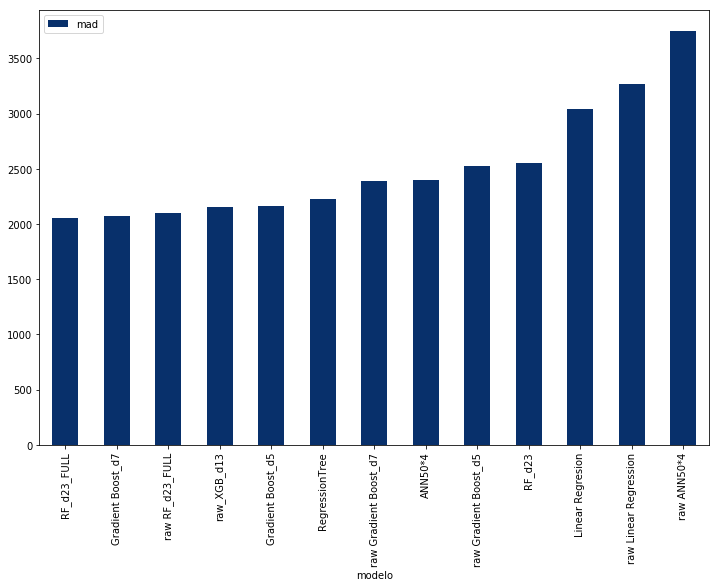

In [48]:
scores_df = scores_df.sort_values(by="mad")
scores_df.plot(kind='bar',y='mad',colormap='Blues_r',figsize=(12, 8))

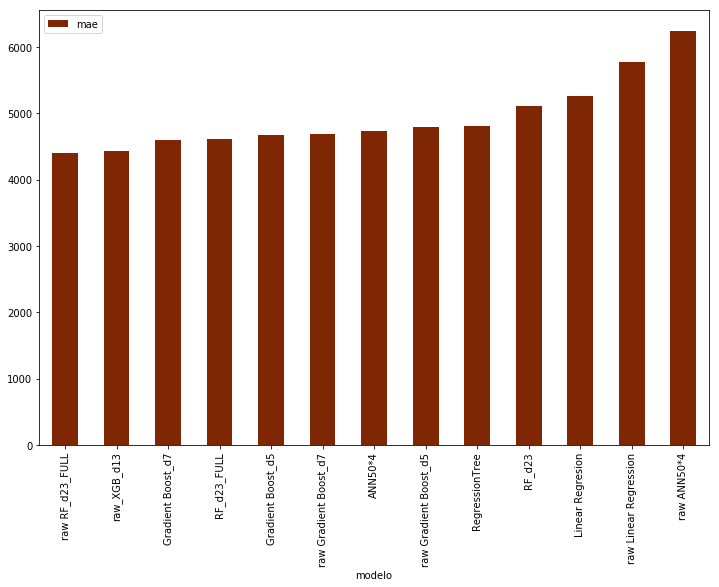

In [49]:
scores_df = scores_df.sort_values(by="mae")
scores_df.plot(kind='bar',y='mae',colormap='Oranges_r',figsize=(12, 8))

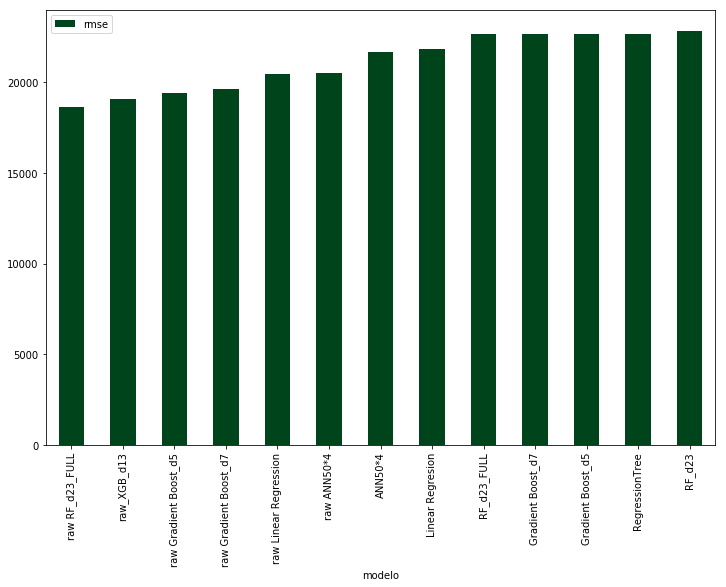

In [50]:
scores_df = scores_df.sort_values(by="rmse")
scores_df.plot(kind='bar',y='rmse',colormap='Greens_r',figsize=(12, 8))

Con la mayoría de modelos, nuestra idea inicial de eliminar outliers había obtenido mejoras muy grandes en MAE y MAD que, a nuestro juicio, compensaban de sobra pequeñas pérdidas en RMSE ya que mejoraban el conjunto de las predicciones. Por tanto, de eso podemos concluir que la presencia de esos clientes con elevado poder adquisitivo resulta una molestia para la capacidad de generalizar de algunos modelos.

Sin embargo, los modelos de Random Forest y Gradient Boosting han demostrado que son capaces de reducir mucho los grandes errores cometidos en algunos clientes puntuales, sin perder a cambio ninguna cantidad importante de MAD. Estos modelos han podido adaptarse al "ruido" introducido por los clientes y realizar predicciones buenas para los clientes con rangos normales de poder adquisitivo, y gracias a que se les ha permitido entrenar con clientes con elevado poder adquisitivo, responden mucho mejor a la hora de predecirlos en el conjunto de test. 

Hemos escogido por tanto entrenar sin eliminar estos clientes "atípicos".

<a name=Optimizacion></a>
## Optimización y combinación de modelos
[Volver al Indice](#Indice)

De todos estos experimentos, se puede observar cómo los modelos más prometedores son el RandomForest y el GradientBoosting implementado sobre XGBoost. Ahora lo que nos gustaría hacer es encontrar los mejores hiperparámetros para estos problemas. Dado un cierto modelo, se puede entender el proceso de encontrar los **hiperparámetros óptimos** como un proceso de optimización de una **función**, que devuelve las métricas de validación cruzada del modelo, y cuyos **argumentos** son los hiperparámetros del modelo. Esta función es difícil de optimizar ya que:

* Es una función **muy costosa** de evaluar, tenemos que entrenar por completo un modelo cada vez que queramos extraer un punto.
* Tiene un **espacio grande** de posibles parámetros/argumentos.
* **Desconocemos la estructura** de este espacio y las **interacciones entre los diferentes argumentos**.

La **Optimización Bayesiana** nos ofrece una solución a este problema, ya que es una técnica pensada para optimizar funciones de tipo **caja-negra** como la que tenemos entre manos.

Usando el paquete BayesianOptimization, definimos como función a optimizar la **puntuación en validación cruzada**, y los argumentos son los diferentes posibles valores de los hiperparámetros. 

Nota: El proceso de optimazación tardará más de una noche en caso de que quiera ejecutarse, por lo que dejamos el código mostrando como se ha realizado, pero no recomendamos su ejecución.

In [ ]:
f_train_df = process_df(shuffled_data,0,train = True)

X_train = f_train_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = f_train_df["Poder_Adquisitivo"].as_matrix()

xgtrain = xgb.DMatrix(X_train, label=y_train)


def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 alpha):

    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['alpha'] = max(alpha, 0)


    cv_result = xgb.cv(params, xgtrain, num_boost_round=100, nfold=5,
             seed=random_state,
             callbacks=[xgb.callback.early_stop(5)])

    return -cv_result['test-mae-mean'].values[-1]





random_state = SEED
num_iter = 50
init_points = 25
params = {
    'eta': 0.1,
    'silent': 1,
    'eval_metric': 'mae',
    'verbose_eval': True,
    'seed': random_state
}

xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight': (1, 20),
                                            'colsample_bytree': (0.1, 1),
                                            'max_depth': (5, 20),
                                            'subsample': (0.5, 1),
                                            'gamma': (0, 15),
                                            'alpha': (0, 15),
                                            })

xgbBO.maximize(init_points=init_points, n_iter=num_iter)

print(xgbBO.res['max'])

In [ ]:
f_train_df = process_df(shuffled_data,0,train = True)

X_train = f_train_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = f_train_df["Poder_Adquisitivo"].as_matrix()

def model_evaluate(n_estimators,
                 max_depth,
                max_features,
                 min_samples_leaf,
                  ):

    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_leaf = int(min_samples_leaf)
    max_features = max(min(max_features, 1), 0.1)

    model = RandomForestRegressor(n_estimators=n_estimators,
                 max_depth=max_depth,
                max_features=max_features,
                 min_samples_leaf=min_samples_leaf,
                                 n_jobs=4,random_state=SEED)

    cv_result = cross_val_score(model,X_train,y_train,cv=kf,scoring="neg_median_absolute_error")

    return np.mean(cv_result)


num_iter = 50
init_points = 10


modelBO_2 = BayesianOptimization(model_evaluate, {'n_estimators': (30, 100),
                                            'max_depth': (17, 27),
                                            'min_samples_leaf': (5, 200),
                                                'max_features' :(0.5,1),
                                            })

modelBO_2.maximize(init_points=init_points, n_iter=num_iter)

print(modelBO_2.res['max'])

Como resultado del proceso de optimización hemos obtenido los siguientes parámetros para los dos modelos:

In [51]:
model = xgb.XGBRegressor(max_depth=30, learning_rate=0.1, alpha=20.0,gamma=13.754,n_estimators=34, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,
                             min_child_weight=78,random_state=SEED)

scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('opt_xgbBoost',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 19121.398081
MAE: 4364.884986
MAD: 2035.221364
CPU times: user 25min 24s, sys: 7.96 s, total: 25min 32s
Wall time: 7min 33s


In [52]:
model = RandomForestRegressor(n_estimators=100,
                 max_depth=27,
                max_features=1.0,
                 min_samples_leaf=5,
                                 n_jobs=4,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('opt_RF',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 18550.904712
MAE: 4379.727630
MAD: 2076.957982


Este proceso nos ha permitido obtener buenas mejoras en el rendimiento de ambos modelos, gracias a la Optimización Bayesiana que ha guiado los hiperparámetros hacia valores mejores.

A la hora de escoger el mejor modelo, una primera aproximación consiste en escoger el modelo que haya obtenido mejores resultados. Otra opción más avanzada consiste en hacer una **combinación de modelos**. Veamos que sucedería si realizaramos una combinación de modelos utilizando el mismo modelo pero cambiando la semilla aleatoria.

In [54]:
splits = []
stk_train_df = process_df(shuffled_data.iloc[:int(shuffled_data.shape[0]*0.8)].copy(),0)
stk_test_df = process_df(shuffled_data.iloc[int(shuffled_data.shape[0]*0.8):].copy(),0)


X_train = stk_train_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = stk_train_df["Poder_Adquisitivo"].as_matrix()

X_test = stk_test_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_test = stk_test_df["Poder_Adquisitivo"].as_matrix()

model_xgb = xgb.XGBRegressor(max_depth=30, learning_rate=0.1, alpha=20.0,gamma=13.754,n_estimators=34, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,
                             min_child_weight=78,random_state=SEED)

model_rf = RandomForestRegressor(n_estimators=100,
                 max_depth=27,
                max_features=1.0,
                 min_samples_leaf=5,
                                 n_jobs=4,random_state=SEED)

model_xgb.fit(X_train,y_train)
residuals_xgb = y_test - model_xgb.predict(X_test)

model_rf.fit(X_train,y_train)
residuals_rf = y_test - model_rf.predict(X_test)


model_xgb2 = xgb.XGBRegressor(max_depth=30, learning_rate=0.1, alpha=20.0,gamma=13.754,n_estimators=34, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,
                             min_child_weight=78,random_state=33)

model_rf2 = RandomForestRegressor(n_estimators=100,
                 max_depth=27,
                max_features=1.0,
                 min_samples_leaf=5,
                                 n_jobs=4,random_state=33)

model_xgb2.fit(X_train,y_train)
residuals_xgb2 = y_test - model_xgb2.predict(X_test)

model_rf2.fit(X_train,y_train)
residuals_rf2 = y_test - model_rf2.predict(X_test)




In [55]:
model_xgb2 = xgb.XGBRegressor(max_depth=30, learning_rate=0.1, alpha=20.0,gamma=13.754,n_estimators=34, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,
                             min_child_weight=78,random_state=55)

model_rf2 = RandomForestRegressor(n_estimators=100,
                 max_depth=27,
                max_features=1.0,
                 min_samples_leaf=5,
                                 n_jobs=4,random_state=55)

model_xgb2.fit(X_train,y_train)
residuals_xgb2 = y_test - model_xgb2.predict(X_test)

model_rf2.fit(X_train,y_train)
residuals_rf2 = y_test - model_rf2.predict(X_test)

Estudiemos la correlación que existe entre los errores que cometen los 4 modelos, 2 Random Forest y 2 Gradient Boosts entrenados con XGBoost, entrenados con diferentes semillas, según la p de Pearson:

In [56]:
df = pd.DataFrame(data={'residuals_rf':residuals_rf,'residuals_xgb':residuals_xgb,'residuals_rf2':residuals_rf2,
                        'residuals_xgb2':residuals_xgb2})
corr = df.corr()
corr

,residuals_rf,residuals_rf2,residuals_xgb,residuals_xgb2
residuals_rf,1.000000,0.993947,0.960267,0.960267
residuals_rf2,0.993947,1.000000,0.956062,0.956062
residuals_xgb,0.960267,0.956062,1.000000,1.000000
residuals_xgb2,0.960267,0.956062,1.000000,1.000000


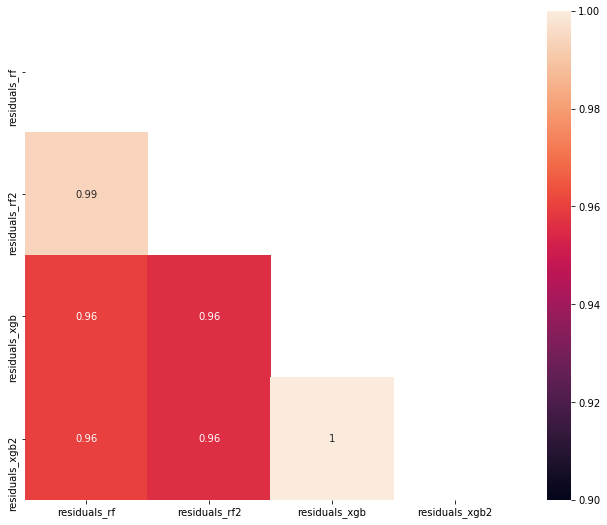

In [57]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,annot=True,vmin=0.9, vmax=1.00)

Podemos ver cómo los errores que comete un tipo de modelo están completamente correlacionados, independientemente de que se haya variado la semilla aleatoria. Por tanto, esto quiere decir que los modelos **cometen los mismos errores**. Hacer una combinación de modelos entrenados con distinta semilla, por tanto, no parece añadir muchas ventajas.

En cambio, los errores cometidos por los modelos xgb y los Random Forest, si bien están fuertemente correlacionados, no son exactamente iguales. Los diferentes modelos no se equivocan, ni en el mismo sitio, ni de la misma manera. Combinar dos modelos diferentes, por tanto, nos aporta **diversidad**, y puede ayudarnos a mejorar los resultados ya que un modelo puede compensar fallos puntuales del otro para ciertos clientes.

Definimos una función para realizar el ensemble mediante una media ponderada de las predicciones de los modelos individuales.

In [62]:
class WeightedEnsemble:
    def __init__(self,models,weights):
        self.models = models
        self.weights = weights
        
    def fit(self,X,y):
        for model in self.models:
            model.fit(X,y)
            
    def predict(self,X):
        y = np.zeros((X.shape[0]))
        for i in range(len(self.models)):
            y += (self.models[i].predict(X) * self.weights[i])
        return y

stk_train_df = stk_test_df = X_train = y_train = X_test = y_test = []
splits = []
splits = get_splits(kf,0)

Entrenamos el modelo combinado.

In [63]:
ensemble = WeightedEnsemble([xgb.XGBRegressor(max_depth=30, learning_rate=0.1, alpha=20.0,gamma=13.754,n_estimators=34, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=78,random_state=SEED),
                            RandomForestRegressor(n_estimators=100,max_depth=27,max_features=1.0,min_samples_leaf=5,
                                                  n_jobs=4,random_state=SEED)],
                            [0.5,0.5])

scores_rmse,scores_mae,scores_mad = train_and_evaluate(ensemble,splits)

print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('Ensemble',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 18629.769274
MAE: 4318.119926
MAD: 2028.135819
CPU times: user 2h 26s, sys: 9.58 s, total: 2h 35s
Wall time: 31min 47s


In [64]:
scores_df = pd.DataFrame(data=scores)

scores_df = scores_df.set_index('modelo')

display(scores_df)

,mad,mae,rmse
modelo,,,
Linear Regresion,3039.409075,5257.209822,21866.239828
ANN50*4,2397.541365,4728.631802,21702.603384
RegressionTree,2223.817397,4802.948535,22670.479224
RF_d23,2549.585133,5112.145407,22861.309229
RF_d23_FULL,2059.083895,4621.045433,22655.050330
Gradient Boost_d5,2163.067239,4675.047281,22660.424748
Gradient Boost_d7,2070.359545,4597.104610,22657.066140
raw Linear Regression,3266.257244,5780.098872,20453.694566
raw ANN50*4,3751.984974,6248.621772,20525.062038


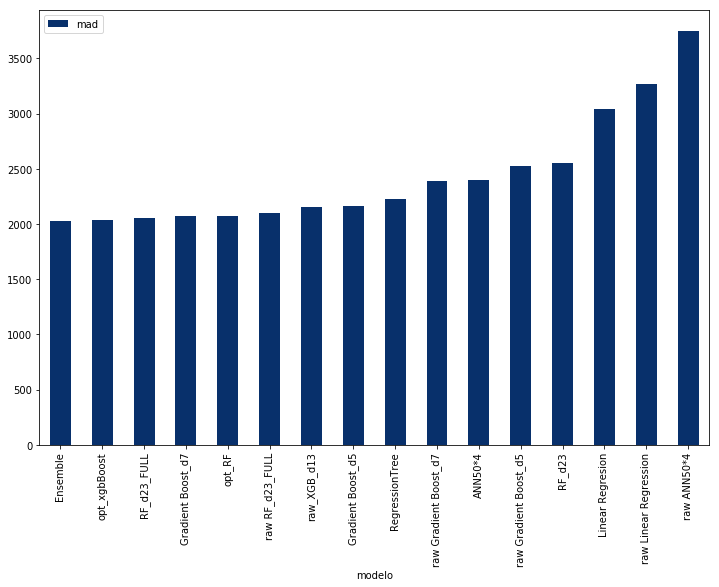

In [65]:
scores_df = scores_df.sort_values(by="mad")
scores_df.plot(kind='bar',y='mad',colormap='Blues_r',figsize=(12, 8))

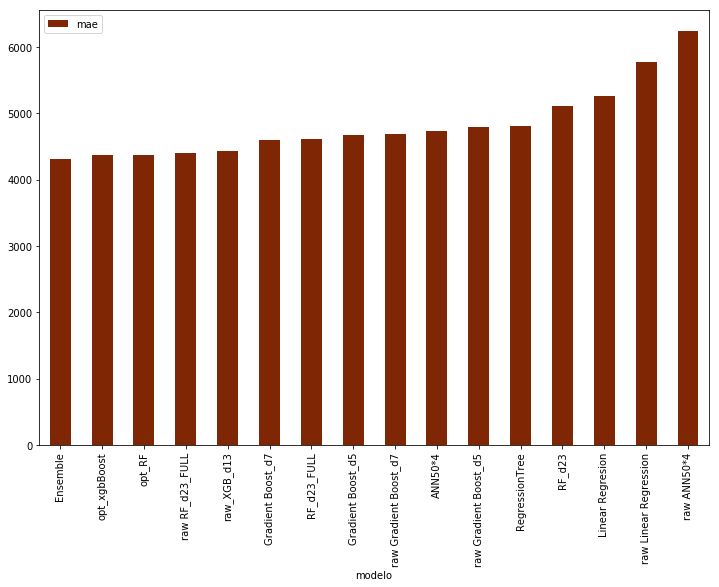

In [66]:
scores_df = scores_df.sort_values(by="mae")
scores_df.plot(kind='bar',y='mae',colormap='Oranges_r',figsize=(12, 8))

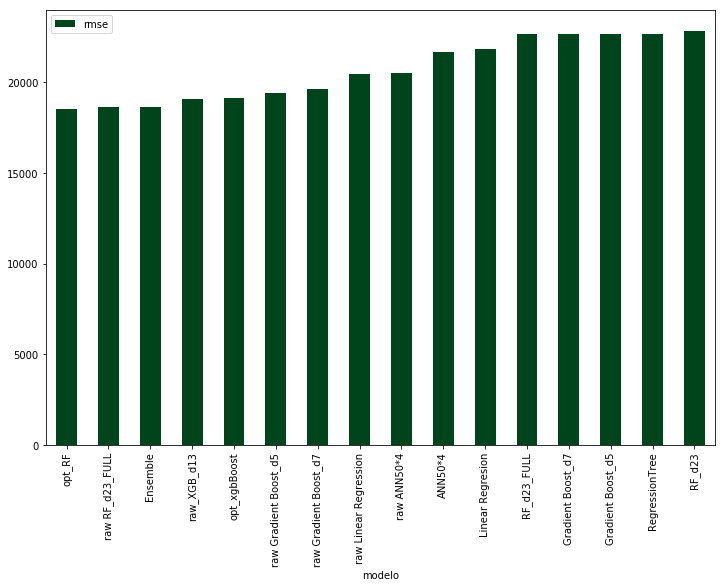

In [67]:
scores_df = scores_df.sort_values(by="rmse")
scores_df.plot(kind='bar',y='rmse',colormap='Greens_r',figsize=(12, 8))

Como resultado final, podemos observar que el Ensemble es el modelo que obtiene mejores resultados en las métricas más relevantes, MAD y MAE. La pequeña diferencia en RMSE se debe a los problemas que ya hemos explicado con esa métrica.

Por tanto, en vista de todos los resultados obtenidos, vamos a realizar la predicción sobre el set de test utilizando este modelo combinado. Pasamos a entrenar el modelo final utilizando todos los datos.

<a name=Predicción></a>
# Predicción
[Volver al Indice](#Indice)

In [68]:
model = WeightedEnsemble([xgb.XGBRegressor(max_depth=30, learning_rate=0.1, alpha=20.0,gamma=13.754,n_estimators=34, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=78,random_state=SEED),
                            RandomForestRegressor(n_estimators=100,max_depth=27,max_features=1.0,min_samples_leaf=5,
                                                  n_jobs=4,random_state=SEED)],
                            [0.5,0.5])

# Entrenamos con todos los datos
f_train_df = process_df(train_df,0,train = True)

x_train = f_train_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = f_train_df["Poder_Adquisitivo"].as_matrix()



model.fit(X=x_train,y=y_train)


test_df = pd.read_csv("data/original/Dataset_Salesforce_Predictive_Modelling_TEST.txt")
ids = test_df["ID_Customer"].copy()
test_df =  process_df(test_df,0,train = False)

x_test = test_df.as_matrix()

# Estiamamos el poder adquisitivo
y = model.predict(X=x_test)




/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Solo nos falta escribir estos resultados en disco.

In [69]:
out = pd.DataFrame(np.stack((ids, y), axis=1, out=None), columns=['ID_Customer', 'PA_Est']).set_index('ID_Customer')
out.to_csv('Test_Mission.txt')

<a name=Anexo1></a>
# Anexo 1: Otros modelos considerados
[Volver al Indice](#Indice)

In [70]:
splits = []
splits = get_splits(kf,1)

In [71]:
model = Lasso(random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)

record_scores('Lasso',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [72]:
model = Ridge(random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)

record_scores('Ridge',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [73]:
model = ElasticNet(random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


record_scores('ElasticNet',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

Todos los modelos lineales parecen obtener resultados comparables. Probamos ahora con redes neuronales.

In [74]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(25,25,25),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


In [75]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(50,50,50),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


In [76]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(25,25,25,25),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


In [77]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(25,25,25,25,25),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


In [78]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=5, max_features='log2',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


In [79]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=7, max_features='log2',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


Podemos ver como la profundidad máxima afecta de manera importante al rendimiento.

In [80]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=17, max_features='log2',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)

record_scores('RF_d17',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [81]:
model = GradientBoostingRegressor(random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


In [82]:
model = GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


Probamos sin eliminar outliers.

In [83]:
splits = []
splits = get_splits(kf,0)

In [84]:
model = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=23, max_features='auto',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)

record_scores('raw RF_d23_n100_FULL',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [85]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=24, max_features='auto',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)

record_scores('raw RF_d24_FULL',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [86]:
scores_df = pd.DataFrame(data=scores)

scores_df = scores_df.set_index('modelo')

display(scores_df)

,mad,mae,rmse
modelo,,,
Linear Regresion,3039.409075,5257.209822,21866.239828
ANN50*4,2397.541365,4728.631802,21702.603384
RegressionTree,2223.817397,4802.948535,22670.479224
RF_d23,2549.585133,5112.145407,22861.309229
RF_d23_FULL,2059.083895,4621.045433,22655.050330
Gradient Boost_d5,2163.067239,4675.047281,22660.424748
Gradient Boost_d7,2070.359545,4597.104610,22657.066140
raw Linear Regression,3266.257244,5780.098872,20453.694566
raw ANN50*4,3751.984974,6248.621772,20525.062038


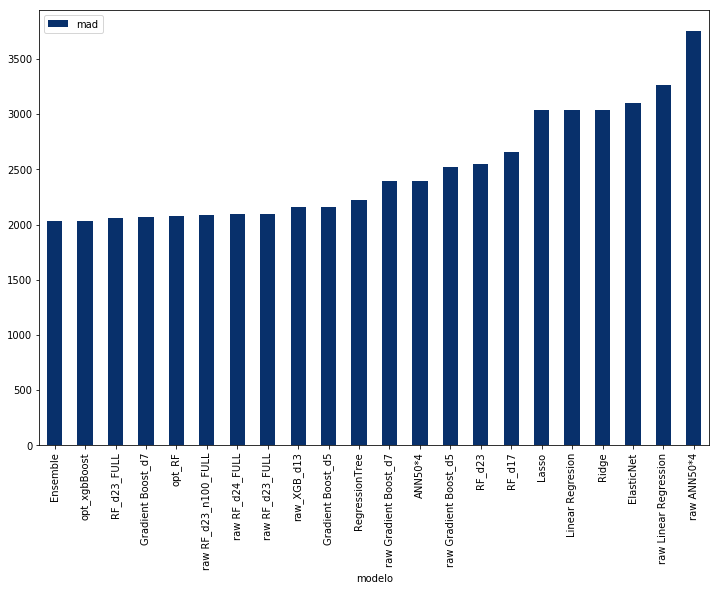

In [87]:
scores_df = scores_df.sort_values(by="mad")
scores_df.plot(kind='bar',y='mad',colormap='Blues_r',figsize=(12, 8))

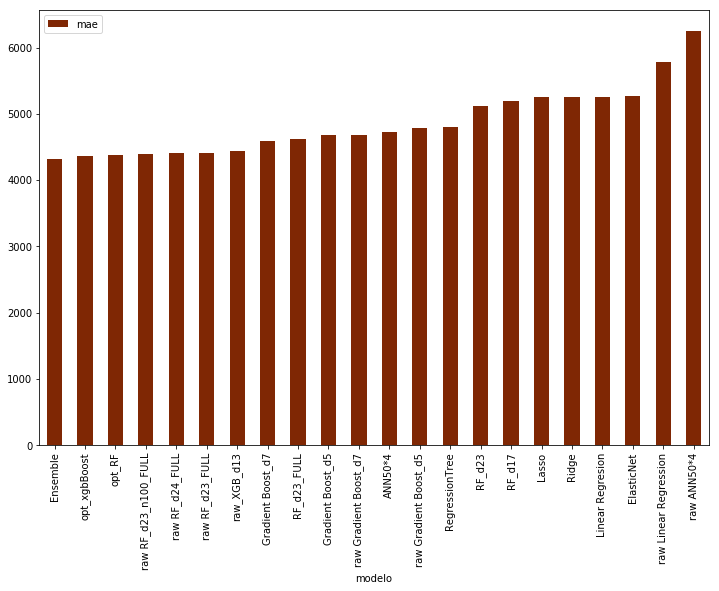

In [88]:
scores_df = scores_df.sort_values(by="mae")
scores_df.plot(kind='bar',y='mae',colormap='Oranges_r',figsize=(12, 8))

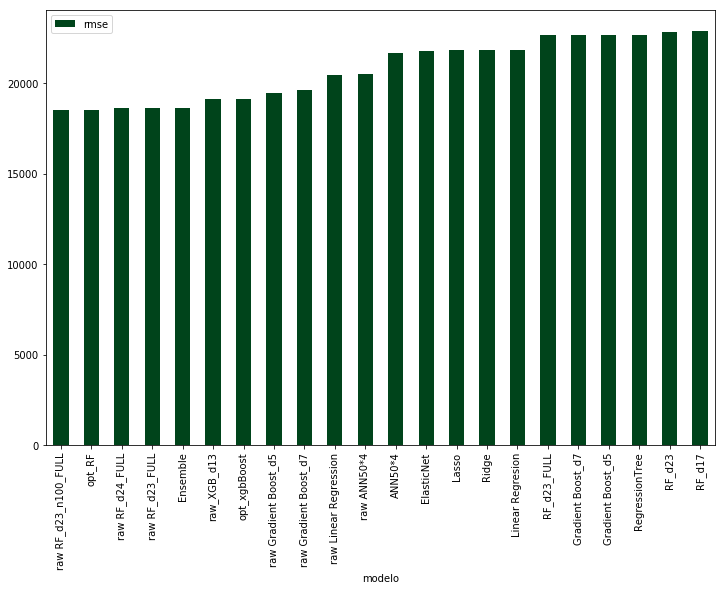

In [89]:
scores_df = scores_df.sort_values(by="rmse")
scores_df.plot(kind='bar',y='rmse',colormap='Greens_r',figsize=(12, 8))